In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pwd

'/Users/robertkaiser/CodingProjects/Kaggle/Apr21Comp'

In [2]:
test = pd.read_csv('Data/test.csv')
test.set_index('PassengerId', inplace = True)
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C


In [3]:
train = pd.read_csv('Data/train.csv')
train.set_index('PassengerId', inplace = True)
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


## Explore Train Data

Aim is to look into the train data-set to find out trends and distributions

### Survival Rate

In [4]:
#Look at survivial rate
train['Survived'].value_counts()

0    57226
1    42774
Name: Survived, dtype: int64

In [5]:
sum(train['Survived'])/len(train['Survived'])
#survival rate is 42%

0.42774

In [6]:
#Suvival by class
train.groupby('Pclass').apply(lambda x: sum(x['Survived'])/len(x))

Pclass
1    0.579779
2    0.525018
3    0.247305
dtype: float64

In [7]:
#Suvival by embarkment point
train.groupby('Embarked').apply(lambda x: sum(x['Survived'])/len(x))

#High rate in Southampton

Embarked
C    0.751296
Q    0.596976
S    0.315294
dtype: float64

In [8]:
train.groupby(['Embarked','Pclass']).apply(lambda x: len(x))

#High southampton rate potentially caused by prevelance of third class pasengers

Embarked  Pclass
C         1         11843
          2          6156
          3          4188
Q         1          3751
          2           844
          3           829
S         1         14635
          2         21609
          3         35895
dtype: int64

In [9]:
train['Sex'].value_counts()

male      56114
female    43886
Name: Sex, dtype: int64

In [10]:
train.groupby('Sex').apply(lambda x: sum(x['Survived'])/len(x))

Sex
female    0.711525
male      0.205795
dtype: float64

In [11]:
train.groupby(['Pclass','Sex']).apply(lambda x: len(x))

Pclass  Sex   
1       female    16084
        male      14231
2       female    15283
        male      13396
3       female    12519
        male      28487
dtype: int64

In [12]:
train.groupby('SibSp').apply(lambda x: sum(x['Survived'])/len(x))


SibSp
0    0.426843
1    0.433748
2    0.453956
3    0.400000
4    0.375856
5    0.189394
8    0.385135
dtype: float64

## Correlation Plot

In [13]:
#Built quick cabin flag to indicate whether they had a cabin or not, may expand to build a "no cabin", "C Floor", "B Floor"... feature
train['CabinFlag'] = train['Cabin'].isna().astype('int')

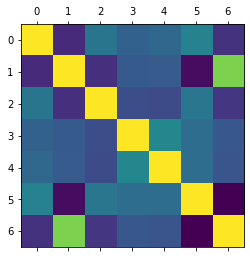

In [14]:
plt.matshow(train.corr())
plt.show()

In [15]:
corr = train.corr()
corr.style.background_gradient(cmap='coolwarm')

,Survived,Pclass,Age,SibSp,Parch,Fare,CabinFlag
Survived,1.000000,-0.289723,0.103895,-0.007587,0.023352,0.187534,-0.251554
Pclass,-0.289723,1.000000,-0.259109,-0.051436,-0.041848,-0.417354,0.709274
Age,0.103895,-0.259109,1.000000,-0.112459,-0.125535,0.109164,-0.233788
SibSp,-0.007587,-0.051436,-0.112459,1.000000,0.213126,0.059358,-0.066946
Parch,0.023352,-0.041848,-0.125535,0.213126,1.000000,0.061443,-0.076096
Fare,0.187534,-0.417354,0.109164,0.059358,0.061443,1.000000,-0.464407
CabinFlag,-0.251554,0.709274,-0.233788,-0.066946,-0.076096,-0.464407,1.000000


In [16]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinFlag
PassengerId,,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S,0
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S,1
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S,1
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S,1
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S,1


## Perform Baskic feature engineering

In [17]:
y = train['Survived']

In [19]:
train['Pclass'] = train['Pclass'].astype('str')
train['CabinFlag'] = train['CabinFlag'].astype('str')

In [20]:
categoricals = ['Pclass', 'Sex', 'Embarked', 'CabinFlag']
trainCat = pd.get_dummies(train[categoricals])
trainCat.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,CabinFlag_0,CabinFlag_1
PassengerId,,,,,,,,,,
0,1,0,0,0,1,0,0,1,1,0
1,0,0,1,0,1,0,0,1,0,1
2,0,0,1,0,1,0,0,1,0,1
3,0,0,1,0,1,0,0,1,0,1
4,0,0,1,0,1,0,0,1,0,1


In [60]:
#need to imput fares, going to imput average per class, per embarkment point
tst = train.groupby('Embarked')['Fare'].transform(lambda x: x.fillna(x.mean()))
tst.head()

ValueError: Length mismatch: Expected axis has 99750 elements, new values have 100000 elements

In [33]:
#not including age at the moment due to the prescence of NA's and cant think of an p
numericals = ['SibSp', 'Parch', 'Fare']
trainNum = train[numericals]
trainNum.head()

,SibSp,Parch,Fare
PassengerId,,,
0,2,0,27.14
1,0,0,13.35
2,1,2,71.29
3,0,0,13.04
4,0,0,7.76


In [61]:
train['Embarked'].isna().value_counts()

False    99750
True       250
Name: Embarked, dtype: int64

In [23]:
test['Age'].isna().value_counts()

False    96513
True      3487
Name: Age, dtype: int64

In [28]:
np.mean(test['Age'])

30.56579642120751

In [29]:
np.mean(train['Age'])

38.35547214294577

In [37]:
X = trainCat


In [38]:
X[numericals] = train[numericals]

In [39]:
X.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,CabinFlag_0,CabinFlag_1,SibSp,Parch,Fare
PassengerId,,,,,,,,,,,,,
0,1,0,0,0,1,0,0,1,1,0,2,0,27.14
1,0,0,1,0,1,0,0,1,0,1,0,0,13.35
2,0,0,1,0,1,0,0,1,0,1,1,2,71.29
3,0,0,1,0,1,0,0,1,0,1,0,0,13.04
4,0,0,1,0,1,0,0,1,0,1,0,0,7.76


## Quick GBM model

In [41]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score


In [44]:
kf = KFold(n_splits=10)
kf.get_n_splits(X)

10

In [42]:
gbm = GradientBoostingClassifier(n_estimators=1000, max_depth=5, random_state=1)

In [45]:
accuracy_model = []

In [48]:
X.describe()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,CabinFlag_0,CabinFlag_1,SibSp,Parch,Fare
count,100000.000000,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,99866.00000
mean,0.303150,0.286790,0.410060,0.43886,0.56114,0.221870,0.054240,0.721390,0.321340,0.678660,0.397690,0.454560,43.92933
std,0.459622,0.452265,0.491847,0.49625,0.49625,0.415506,0.226492,0.448317,0.466993,0.466993,0.862566,0.950076,69.58882
min,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.68000
25%,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.04000
50%,0.000000,0.000000,0.000000,0.00000,1.00000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,24.46000
75%,1.000000,1.000000,1.000000,1.00000,1.00000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,33.50000
max,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,9.000000,744.66000


In [47]:
X.isnull().values.any()

True

In [46]:
for train_index, test_index in kf.split(X):
    # Split train-test
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Train the model
    model = gbm.fit(X_train, y_train)
    # Append to accuracy_model the accuracy of the model
    accuracy_model.append(accuracy_score(y_test, model.predict(X_test), normalize=True)*100)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').